**In this notebook I test the idea of building a model that uses some aggregated statistics about the catchment the model is predicting on AND the statistics of the neighbouring area. As aggregated statistics I used:**
*   Minimum
*   Maximum
* Mean
* Median
* Quantiles (every 10%)

**The image below represents the radar (color of the catchment) and the rain gauge measuements (color of the points). The scala is also represented below and goes from violet (no precipitation) to yellow (heavy rain).**

**By looking at the map that shows rain gauges and radar measurements, it is possible to notice that sometimes the two measurements are not correlated. As shown in the image below, radar data measured heavy precipitations for that particular day in the central catchment (inside the red circle), in fact its color is green/yellow. However, the rain gauges that are within the catchment didn't measure any precipitation (violet color).**

**By using both the measurements of the rain gauges inside the cacthment and the neighbouring ones, I hope to increase the prediction score.**  


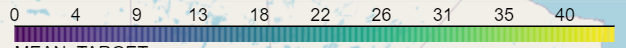

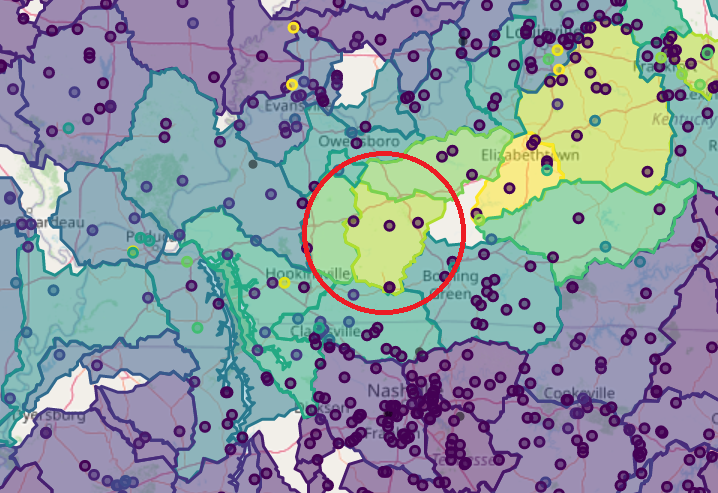

**The database has been uploaded on snowflake for the duration of the project. It won't be available at the time you read this notebook. The commented out part of the following cells are only needed for setting up the connection with snowflake.**

In [ ]:
#!pip install snowflake-connector-python
!pip install pyarrow==8.0.0
!pip install tensorflow-addons
%pip install geopandas
%pip install Fiona
%pip install folium matplotlib mapclassify
!pip install snowflake-connector-python
!pip install tpot
!pip install shap

In [ ]:
#import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import folium
#import snowflake.connector
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import cross_val_score
from math import sqrt


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.legend()
  plt.grid(True)


# ctx = snowflake.connector.connect(
#                 user="...",
#                 password="...",
#                 account="rz80876",
#                 region="eu-central-1",
#                 warehouse="PUBLIC",
#                 database="RAIN",
#                 schema="PUBLIC"
#                 )

pd.set_option('display.max_columns', None)


## Area in the US south east


For an initial test of the model performance I selected an area the considers the catchments which have a centroid between the 35th and the 37th parallels and the 80th and 82nd meridians, as it was shown to have enough rain gauges measurements. However the same method could be applied to any other area.

Since the database won't be online after the handout, I saved the dataframe resulting from the query in the file called "us_south_east_agg_stat.csv".

In [ ]:
# sql_query = """SELECT  m.station, m.measurement_date , MONTH(m.measurement_date), m.prcp, t.mean_target, f.HYBAS_ID, c.Area, c.Altitude_Mean, c.Num_Gauges, c.Side, c.Coast, c.Lake, c.Slope_Mean, c.centroid_latitude, c.centroid_longitude
# FROM catchment_features c
# INNER JOIN precipitation_gauge_features f ON f.hybas_id = c.hybas_id
# INNER JOIN precipitation_gauge_measurements m ON m.station = f.station 
# INNER JOIN second_target t ON t.zone = c.hybas_id AND t.date_target = m.measurement_date
# WHERE c.CENTROID_LATITUDE < 37 AND c.CENTROID_LATITUDE > 35 AND c.CENTROID_LONGITUDE  > -82 AND c.CENTROID_LONGITUDE  < -80;"""

# cursor = ctx.cursor()
# cursor.execute(sql_query)
# data = cursor.fetchall()
# num_fields = len(cursor.description)
# columns = [i[0].lower() for i in cursor.description]
# df = pd.DataFrame(data, columns=columns)
# cursor.close()

True

In [ ]:
df = pd.read_csv('us_south_east_agg_stat.csv')

In [ ]:
df["measurement_date"] = pd.to_datetime(df["measurement_date"])
df["hybas_id"] = df["hybas_id"].astype(int)
df["prcp"] = df["prcp"].astype(float)
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605787 entries, 0 to 616504
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   station                    605787 non-null  object        
 1   measurement_date           605787 non-null  datetime64[ns]
 2   month(m.measurement_date)  605787 non-null  int64         
 3   prcp                       605787 non-null  float64       
 4   mean_target                605787 non-null  float64       
 5   hybas_id                   605787 non-null  int64         
 6   area                       605787 non-null  float64       
 7   altitude_mean              605787 non-null  float64       
 8   num_gauges                 605787 non-null  int64         
 9   side                       605787 non-null  object        
 10  coast                      605787 non-null  int64         
 11  lake                       605787 non-null  int64   

In [ ]:
df.shape

(605787, 15)

In [ ]:
df.station.nunique()

255

In [ ]:
df.hybas_id.nunique()

20

In [ ]:
df.measurement_date.nunique()

4199

In [ ]:
df.hybas_id.unique()

array([7070614140, 7070624010, 7070663220, 7070663440, 7070661200,
       7070661260, 7070614270, 7070610540, 7070620930, 7070656490,
       7070656320, 7070630060, 7070656220, 7070638920, 7070651020,
       7070643040, 7070630010, 7070639030, 7070643030, 7070656440])

The dataframe contains, for each row: 


*   rain gauge measurement (prcp)
*   name of the rain gauge station (station)
*   the date of the measurement (measurement_date)
*   the radar measurement, which is our target variable (mean_target)
*   name of the catchment/watershed (hybas_id)
*   the position in latitude and longitude of the center of the catchment/watershed (centroid_latitude/longitude)
*   other characterists relative to the catchment (altitude_mean, num_gauges etc.)



In [ ]:
df.head()

,station,measurement_date,month(m.measurement_date),prcp,mean_target,hybas_id,area,altitude_mean,num_gauges,side,coast,lake,slope_mean,centroid_latitude,centroid_longitude
0,USC00443272,2010-08-01,8,24.1,0.004688,7070614140,4.737519e+09,881.629906,27,M,0,0,10.822695,36.638048,-81.235767
1,USC00443272,2010-08-02,8,0.0,0.000000,7070614140,4.737519e+09,881.629906,27,M,0,0,10.822695,36.638048,-81.235767
2,USC00443272,2010-08-03,8,0.0,0.002859,7070614140,4.737519e+09,881.629906,27,M,0,0,10.822695,36.638048,-81.235767
3,USC00443272,2010-08-04,8,0.0,6.471771,7070614140,4.737519e+09,881.629906,27,M,0,0,10.822695,36.638048,-81.235767
4,USC00443272,2010-08-05,8,1.0,36.834029,7070614140,4.737519e+09,881.629906,27,M,0,0,10.822695,36.638048,-81.235767


Each catchment has multiple rain gauges measurements for the same date. The following cell calculates the aggregated statistics for each catchment and date.

In [ ]:
hyb = df.groupby(['hybas_id', 'measurement_date', "mean_target", "area", "altitude_mean", "month(m.measurement_date)", "num_gauges", "slope_mean", "coast", "lake", "centroid_latitude", "centroid_longitude"])['prcp'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.10),lambda x: x.quantile(0.20), lambda x: x.quantile(0.30), lambda x: x.quantile(0.40) ,lambda x: x.quantile(0.60), lambda x: x.quantile(0.70), lambda x: x.quantile(0.80), lambda x: x.quantile(0.90)])

hyb = hyb.rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q2', '<lambda_2>': 'q3', '<lambda_3>': 'q4', '<lambda_4>': 'q6', '<lambda_5>': 'q7', '<lambda_6>': 'q8', '<lambda_7>': 'q9'})

hyb = hyb.reset_index()

In [ ]:
hyb.shape

(77846, 24)

The first five rows have the same aggregated statistics value. This is given by the fact that the catchment they refer to has just one rain gauge inside its border. 

In [ ]:
hyb

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min,max,mean,median,q1,q2,q3,q4,q6,q7,q8,q9
0,7070610540,2015-07-01,0.340144,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,5.1,5.1,5.100000,5.1,5.1,5.10,5.10,5.10,5.10,5.1,5.10,5.10
1,7070610540,2015-07-02,3.380523,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,0.5,0.5,0.500000,0.5,0.5,0.50,0.50,0.50,0.50,0.5,0.50,0.50
2,7070610540,2015-07-03,11.596402,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,1.0,1.0,1.000000,1.0,1.0,1.00,1.00,1.00,1.00,1.0,1.00,1.00
3,7070610540,2015-07-04,2.330972,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,28.2,28.2,28.200000,28.2,28.2,28.20,28.20,28.20,28.20,28.2,28.20,28.20
4,7070610540,2015-07-05,9.564361,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,1.8,1.8,1.800000,1.8,1.8,1.80,1.80,1.80,1.80,1.8,1.80,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77841,7070663440,2021-06-26,0.000000,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00
77842,7070663440,2021-06-27,0.006937,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,0.0,0.5,0.125000,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.30,0.50
77843,7070663440,2021-06-28,0.035328,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00
77844,7070663440,2021-06-29,0.058043,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,0.8,6.6,2.511111,1.3,0.8,0.92,1.00,1.06,2.26,2.5,3.94,6.20


In [ ]:
hyb[hyb.mean_target > 5]

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min,max,mean,median,q1,q2,q3,q4,q6,q7,q8,q9
2,7070610540,2015-07-03,11.596402,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,7070610540,2015-07-05,9.564361,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,1.8,1.8,1.80,1.80,1.80,1.80,1.80,1.80,1.80,1.80,1.80,1.80
7,7070610540,2015-07-08,5.561802,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,4.1,4.1,4.10,4.10,4.10,4.10,4.10,4.10,4.10,4.10,4.10,4.10
10,7070610540,2015-07-11,5.648961,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,6.1,6.1,6.10,6.10,6.10,6.10,6.10,6.10,6.10,6.10,6.10,6.10
12,7070610540,2015-07-13,35.211388,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,37.1,37.1,37.10,37.10,37.10,37.10,37.10,37.10,37.10,37.10,37.10,37.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77824,7070663440,2021-06-09,11.539188,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,0.8,5.1,2.47,2.75,0.80,0.80,0.80,1.82,3.12,3.30,3.50,4.38
77826,7070663440,2021-06-11,8.859426,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
77827,7070663440,2021-06-12,9.825754,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,2.0,29.7,14.30,10.40,2.00,3.68,6.76,9.84,17.92,20.40,24.28,29.54
77835,7070663440,2021-06-20,42.592191,1.338045e+09,274.763423,6,15,4.662411,0,0,35.063894,-81.962848,4.3,35.6,19.30,22.60,5.91,6.80,8.50,18.30,24.16,24.37,28.48,32.52


While the previous cells calculated the statistics for each single catchment, the following one calculates the same statistics for the whole area

In [ ]:
area = df.groupby(['measurement_date'])['prcp'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.10),lambda x: x.quantile(0.20), lambda x: x.quantile(0.30), lambda x: x.quantile(0.40) ,lambda x: x.quantile(0.60), lambda x: x.quantile(0.70), lambda x: x.quantile(0.80), lambda x: x.quantile(0.90)])

area = area.rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q2', '<lambda_2>': 'q3', '<lambda_3>': 'q4', '<lambda_4>': 'q6', '<lambda_5>': 'q7', '<lambda_6>': 'q8', '<lambda_7>': 'q9'})

area = area.reset_index()

In [ ]:
area.shape

(4199, 13)

In [ ]:
area.head(5)

,measurement_date,min,max,mean,median,q1,q2,q3,q4,q6,q7,q8,q9
0,2010-01-01,0.0,9.1,1.083871,0.8,0.0,0.0,0.0,0.46,0.8,1.3,1.5,2.8
1,2010-01-02,0.0,3.8,0.073913,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,2010-01-03,0.0,0.3,0.006742,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,2010-01-04,0.0,5.1,0.078723,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,2010-01-05,0.0,7.1,0.224176,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.3


The two dataframes can now be merged. After the merge, each row will have:
* a date (measurement_date)
* the target column (mean_target)
* some features relative to the catchment (area, altitude_mean,	num_gauges, slope_mean,	coast,	lake,	centroid_latitude, centroid_longitude)
* the aggregated statistical data for the catchment(min_x,	max_x,	mean_x	median_x,	q1_x,	q2_x,	q3_x,	q4_x,	q6_x,	q7_x,	q8_x,	q9_x)
* the aggregated statistical data for the entire area(min_y,	max_y,	mean_y,	median_y,	q1_y,	q2_y,	q3_y,	q4_y,	q6_y,	q7_y,	q8_y,	q9_y)

In [ ]:
hyb = pd.merge(hyb, area, how='inner', on="measurement_date")

In [ ]:
hyb.head()

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min_x,max_x,mean_x,median_x,q1_x,q2_x,q3_x,q4_x,q6_x,q7_x,q8_x,q9_x,min_y,max_y,mean_y,median_y,q1_y,q2_y,q3_y,q4_y,q6_y,q7_y,q8_y,q9_y
0,7070610540,2015-07-01,0.340144,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,5.1,5.1,5.100000,5.10,5.10,5.10,5.10,5.10,5.10,5.10,5.10,5.10,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
1,7070614140,2015-07-01,1.033225,4.737519e+09,881.629906,7,27,10.822695,0,0,36.638048,-81.235767,0.0,19.6,3.333333,0.65,0.00,0.00,0.00,0.40,1.04,2.90,4.90,10.17,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
2,7070614270,2015-07-01,0.066523,9.156176e+08,794.972580,7,2,9.975012,0,0,36.795321,-80.620845,10.4,10.4,10.400000,10.40,10.40,10.40,10.40,10.40,10.40,10.40,10.40,10.40,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
3,7070620930,2015-07-01,0.951222,6.175200e+08,728.012906,7,2,9.200159,0,0,36.818482,-81.604655,3.6,5.1,4.350000,4.35,3.75,3.90,4.05,4.20,4.50,4.65,4.80,4.95,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
4,7070624010,2015-07-01,2.301924,1.869612e+09,677.798982,7,3,13.501952,0,0,36.810239,-81.998598,0.0,0.3,0.150000,0.15,0.03,0.06,0.09,0.12,0.18,0.21,0.24,0.27,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1


In [ ]:
hyb[hyb.mean_target > 5]

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min_x,max_x,mean_x,median_x,q1_x,q2_x,q3_x,q4_x,q6_x,q7_x,q8_x,q9_x,min_y,max_y,mean_y,median_y,q1_y,q2_y,q3_y,q4_y,q6_y,q7_y,q8_y,q9_y
25,7070630010,2015-07-02,8.897544,8.244065e+08,424.343037,7,3,7.274997,0,0,36.510472,-80.596129,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,23.9,1.395604,0.30,0.0,0.0,0.0,0.0,0.5,1.00,2.0,3.80
40,7070610540,2015-07-03,11.596402,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,1.0,1.0,1.000000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,33.0,2.850581,0.50,0.0,0.0,0.0,0.0,0.8,1.21,2.3,12.12
41,7070614140,2015-07-03,17.340057,4.737519e+09,881.629906,7,27,10.822695,0,0,36.638048,-81.235767,0.0,11.4,2.350000,1.15,0.27,0.30,0.50,0.80,1.70,2.00,3.36,6.33,0.0,33.0,2.850581,0.50,0.0,0.0,0.0,0.0,0.8,1.21,2.3,12.12
42,7070614270,2015-07-03,10.865106,9.156176e+08,794.972580,7,2,9.975012,0,0,36.795321,-80.620845,5.1,5.1,5.100000,5.10,5.10,5.10,5.10,5.10,5.10,5.10,5.10,5.10,0.0,33.0,2.850581,0.50,0.0,0.0,0.0,0.0,0.8,1.21,2.3,12.12
43,7070620930,2015-07-03,15.892469,6.175200e+08,728.012906,7,2,9.200159,0,0,36.818482,-81.604655,12.2,21.1,16.650000,16.65,13.09,13.98,14.87,15.76,17.54,18.43,19.32,20.21,0.0,33.0,2.850581,0.50,0.0,0.0,0.0,0.0,0.8,1.21,2.3,12.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77695,7070651020,2021-06-22,7.134215,2.062726e+09,225.396972,6,9,3.180186,0,0,35.701729,-80.260672,0.0,38.1,7.616667,0.00,0.00,0.00,0.00,0.00,0.00,3.80,7.60,22.85,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.8,4.10,7.5,10.83
77696,7070656220,2021-06-22,8.055895,1.688548e+09,307.614069,6,15,5.085133,0,0,35.514701,-81.333965,0.0,5.8,0.940000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,3.82,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.8,4.10,7.5,10.83
77697,7070656320,2021-06-22,14.375168,5.477020e+09,428.334701,6,43,8.272574,0,0,35.733237,-81.495125,0.0,13.0,3.215385,0.90,0.00,0.00,0.00,0.00,1.80,4.45,7.10,10.55,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.8,4.10,7.5,10.83
77701,7070663220,2021-06-22,10.307097,4.754251e+09,338.147392,6,36,6.595088,0,0,35.304356,-81.812492,0.0,4.8,1.012500,0.00,0.00,0.00,0.00,0.00,0.50,1.40,2.50,2.80,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.8,4.10,7.5,10.83


Since a real model should be able to predict the radar measurement of previously unseen days, I create a train and test split based on the date. If we do a normal train ad test split, there's a risk of data leakage.

In [ ]:
dates= hyb.measurement_date.unique()

In [ ]:
dates_train ,dates_test = train_test_split(dates,test_size=0.2, random_state = 40) 


In [ ]:
dates_train.shape

(3359,)

In [ ]:
dates_test.shape

(840,)

In [ ]:
train = hyb[(hyb.measurement_date.isin(dates_train))]
test = hyb[(hyb.measurement_date.isin(dates_test))]



In [ ]:
train.shape

(62281, 36)

In [ ]:
test.shape

(15565, 36)

In [ ]:
train.head(5)

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min_x,max_x,mean_x,median_x,q1_x,q2_x,q3_x,q4_x,q6_x,q7_x,q8_x,q9_x,min_y,max_y,mean_y,median_y,q1_y,q2_y,q3_y,q4_y,q6_y,q7_y,q8_y,q9_y
0,7070610540,2015-07-01,0.340144,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,5.1,5.1,5.100000,5.10,5.10,5.10,5.10,5.10,5.10,5.10,5.10,5.10,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
1,7070614140,2015-07-01,1.033225,4.737519e+09,881.629906,7,27,10.822695,0,0,36.638048,-81.235767,0.0,19.6,3.333333,0.65,0.00,0.00,0.00,0.40,1.04,2.90,4.90,10.17,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
2,7070614270,2015-07-01,0.066523,9.156176e+08,794.972580,7,2,9.975012,0,0,36.795321,-80.620845,10.4,10.4,10.400000,10.40,10.40,10.40,10.40,10.40,10.40,10.40,10.40,10.40,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
3,7070620930,2015-07-01,0.951222,6.175200e+08,728.012906,7,2,9.200159,0,0,36.818482,-81.604655,3.6,5.1,4.350000,4.35,3.75,3.90,4.05,4.20,4.50,4.65,4.80,4.95,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1
4,7070624010,2015-07-01,2.301924,1.869612e+09,677.798982,7,3,13.501952,0,0,36.810239,-81.998598,0.0,0.3,0.150000,0.15,0.03,0.06,0.09,0.12,0.18,0.21,0.24,0.27,0.0,22.4,2.28254,0.0,0.0,0.0,0.0,0.0,0.8,1.8,3.42,8.1


In [ ]:
train[train.mean_target > 5]

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min_x,max_x,mean_x,median_x,q1_x,q2_x,q3_x,q4_x,q6_x,q7_x,q8_x,q9_x,min_y,max_y,mean_y,median_y,q1_y,q2_y,q3_y,q4_y,q6_y,q7_y,q8_y,q9_y
25,7070630010,2015-07-02,8.897544,8.244065e+08,424.343037,7,3,7.274997,0,0,36.510472,-80.596129,0.0,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,23.9,1.395604,0.30,0.0,0.0,0.0,0.0,0.50,1.00,2.0,3.80
63,7070620930,2015-07-04,5.182004,6.175200e+08,728.012906,7,2,9.200159,0,0,36.818482,-81.604655,35.8,58.4,47.100000,47.1,38.06,40.32,42.58,44.84,49.36,51.62,53.88,56.14,0.0,58.4,11.015934,6.40,0.0,0.3,0.8,3.0,10.32,15.85,20.5,29.65
64,7070624010,2015-07-04,5.692551,1.869612e+09,677.798982,7,3,13.501952,0,0,36.810239,-81.998598,12.7,22.9,17.966667,18.3,13.82,14.94,16.06,17.18,19.22,20.14,21.06,21.98,0.0,58.4,11.015934,6.40,0.0,0.3,0.8,3.0,10.32,15.85,20.5,29.65
140,7070610540,2015-07-08,5.561802,8.850506e+08,745.979904,7,1,8.913439,0,0,36.971022,-80.381522,4.1,4.1,4.100000,4.1,4.10,4.10,4.10,4.10,4.10,4.10,4.10,4.10,0.0,17.3,0.471111,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.32
156,7070661200,2015-07-08,5.411183,7.133384e+08,204.959269,7,9,2.746187,0,0,35.144556,-80.843271,0.0,1.0,0.166667,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.0,17.3,0.471111,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77695,7070651020,2021-06-22,7.134215,2.062726e+09,225.396972,6,9,3.180186,0,0,35.701729,-80.260672,0.0,38.1,7.616667,0.0,0.00,0.00,0.00,0.00,0.00,3.80,7.60,22.85,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.80,4.10,7.5,10.83
77696,7070656220,2021-06-22,8.055895,1.688548e+09,307.614069,6,15,5.085133,0,0,35.514701,-81.333965,0.0,5.8,0.940000,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.72,3.82,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.80,4.10,7.5,10.83
77697,7070656320,2021-06-22,14.375168,5.477020e+09,428.334701,6,43,8.272574,0,0,35.733237,-81.495125,0.0,13.0,3.215385,0.9,0.00,0.00,0.00,0.00,1.80,4.45,7.10,10.55,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.80,4.10,7.5,10.83
77701,7070663220,2021-06-22,10.307097,4.754251e+09,338.147392,6,36,6.595088,0,0,35.304356,-81.812492,0.0,4.8,1.012500,0.0,0.00,0.00,0.00,0.00,0.50,1.40,2.50,2.80,0.0,38.1,3.877465,0.15,0.0,0.0,0.0,0.0,1.80,4.10,7.5,10.83


In [ ]:
train.isnull().sum()

hybas_id                     0
measurement_date             0
mean_target                  0
area                         0
altitude_mean                0
month(m.measurement_date)    0
num_gauges                   0
slope_mean                   0
coast                        0
lake                         0
centroid_latitude            0
centroid_longitude           0
min_x                        0
max_x                        0
mean_x                       0
median_x                     0
q1_x                         0
q2_x                         0
q3_x                         0
q4_x                         0
q6_x                         0
q7_x                         0
q8_x                         0
q9_x                         0
min_y                        0
max_y                        0
mean_y                       0
median_y                     0
q1_y                         0
q2_y                         0
q3_y                         0
q4_y                         0
q6_y    

In [ ]:
X_train = train.drop(columns=['mean_target', "measurement_date", "hybas_id"])
y_train = train['mean_target'] 

X_test = test.drop(columns=['mean_target', "measurement_date", "hybas_id"])
y_test = test['mean_target']

In [ ]:
from xgboost import XGBRegressor


scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
xgb = XGBRegressor(n_estimators=200, max_depth = 20)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.1480218447278394

**The score is not great, but the dataframe which was used to train the model has only 60K rows. Maybe the model can be improved by considering multiple areas, which is what I tested in the next section**

## Considering multiple areas

**With the following code, I do the same thing the previous cells did, but for multiple areas. By combining multiple areas, maybe the score could improve as the model learns on more data.**

Since considering the whole US would take too long, I only consider the area between the 20th ans the 50th parallels and the 60th and 90th meridians. This area has been chosen because it had enough rain gauges measurements. Each 2x2 area is considered sequentially and its dataframe is added to the final dataframe. An area will be considered only if it has enough catchments(>2) or enough rain gauges (>10).

Since the database won't be online after the  handover, I saved the resulting dataframe in the file called "60_90_agg_stat.csv"

In [ ]:
latitude = range(20,50,2)
longitude = range(-90,-60,2)

In [ ]:
fin_df = pd.DataFrame()
for lat in latitude:
  for lon in longitude:
      sql_query = """SELECT  m.station, m.measurement_date , MONTH(m.measurement_date), m.prcp, t.mean_target, f.HYBAS_ID, c.Area, c.Altitude_Mean, c.Num_Gauges, c.Side, c.Coast, c.Lake, c.Slope_Mean, c.centroid_latitude, c.centroid_longitude
      FROM catchment_features c
      INNER JOIN precipitation_gauge_features f ON f.hybas_id = c.hybas_id
      INNER JOIN precipitation_gauge_measurements m ON m.station = f.station 
      INNER JOIN second_target t ON t.zone = c.hybas_id AND t.date_target = m.measurement_date
      WHERE c.CENTROID_LATITUDE < """+str(lat+2)+""" AND c.CENTROID_LATITUDE >"""+str(lat)+""" AND c.CENTROID_LONGITUDE  >"""+str(lon-2)+""" AND c.CENTROID_LONGITUDE  < """+str(lon)+""";"""

      cursor = ctx.cursor()
      cursor.execute(sql_query)
      data = cursor.fetchall()
      num_fields = len(cursor.description)
      columns = [i[0].lower() for i in cursor.description]
      df = pd.DataFrame(data, columns=columns)
      cursor.close()

      if (df.station.nunique() < 10) | (df.hybas_id.nunique() < 2):
        print("ignored area:") 
        print(lat,lon)
        continue
      else:
        print("not ignored area:")
        print(lat,lon)


      df["measurement_date"] = pd.to_datetime(df["measurement_date"])
      df["hybas_id"] = df["hybas_id"].astype(int)
      df["prcp"] = df["prcp"].astype(float)
      df = df.dropna()

      hyb = df.groupby(['hybas_id', 'measurement_date', "mean_target", "area", "altitude_mean", "month(m.measurement_date)", "num_gauges", "slope_mean", "coast", "lake", "centroid_latitude", "centroid_longitude"])['prcp'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.10),lambda x: x.quantile(0.20), lambda x: x.quantile(0.30), lambda x: x.quantile(0.40) ,lambda x: x.quantile(0.60), lambda x: x.quantile(0.70), lambda x: x.quantile(0.80), lambda x: x.quantile(0.90)])


      hyb = hyb.rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q2', '<lambda_2>': 'q3', '<lambda_3>': 'q4', '<lambda_4>': 'q6', '<lambda_5>': 'q7', '<lambda_6>': 'q8', '<lambda_7>': 'q9'})

      hyb = hyb.reset_index()

      area = df.groupby(['measurement_date'])['prcp'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.10),lambda x: x.quantile(0.20), lambda x: x.quantile(0.30), lambda x: x.quantile(0.40) ,lambda x: x.quantile(0.60), lambda x: x.quantile(0.70), lambda x: x.quantile(0.80), lambda x: x.quantile(0.90)])

      area = area.rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q2', '<lambda_2>': 'q3', '<lambda_3>': 'q4', '<lambda_4>': 'q6', '<lambda_5>': 'q7', '<lambda_6>': 'q8', '<lambda_7>': 'q9'})

      area = area.reset_index()

      hyb = pd.merge(hyb, area, how='inner', on="measurement_date")

      fin_df = pd.concat([fin_df, hyb], axis=0, ignore_index=True)

In [ ]:
fin_df = pd.read_csv('60_90_agg_stat.csv')

**The entire dataframe has now more than 2M rows.**

In [ ]:
fin_df.shape

(2244219, 36)

The final dataframe contains:
* a date (measurement_date)
* the catchment name (hybas_id)
* the target column (mean_target)
* some features relative to the catchment (area, altitude_mean,	num_gauges, slope_mean,	coast,	lake,	centroid_latitude, centroid_longitude)
* the aggregated statistical data for the catchment(min_x,	max_x,	mean_x	median_x,	q1_x,	q2_x,	q3_x,	q4_x,	q6_x,	q7_x,	q8_x,	q9_x)
* the aggregated statistical data for the entire area(min_y,	max_y,	mean_y,	median_y,	q1_y,	q2_y,	q3_y,	q4_y,	q6_y,	q7_y,	q8_y,	q9_y)

In [ ]:
fin_df.head()

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min_x,max_x,mean_x,median_x,q1_x,q2_x,q3_x,q4_x,q6_x,q7_x,q8_x,q9_x,min_y,max_y,mean_y,median_y,q1_y,q2_y,q3_y,q4_y,q6_y,q7_y,q8_y,q9_y
0,7070044300,2010-01-01,8.620607,4.632893e+08,1.059958,1,11,0.171777,1,0,25.911027,-80.199741,0.0,5.1,1.600000,0.00,0.0,0.0,0.00,0.00,0.78,2.00,4.10,4.92,0.0,8.1,1.860,0.0,0.0,0.0,0.0,0.00,0.52,2.74,4.4,6.18
1,7070044360,2010-01-01,8.991110,3.198715e+09,-0.233478,1,17,0.036914,1,0,25.305525,-80.677108,0.0,6.9,1.500000,0.00,0.0,0.0,0.00,0.00,1.00,2.59,2.80,3.21,0.0,8.1,1.860,0.0,0.0,0.0,0.0,0.00,0.52,2.74,4.4,6.18
2,7070064920,2010-01-01,6.028245,5.099125e+08,0.028417,1,10,0.050833,1,0,24.667076,-81.558281,0.0,8.1,2.537500,0.00,0.0,0.0,0.00,0.00,0.86,3.87,6.46,7.96,0.0,8.1,1.860,0.0,0.0,0.0,0.0,0.00,0.52,2.74,4.4,6.18
3,7070044300,2010-01-02,0.032901,4.632893e+08,1.059958,1,11,0.171777,1,0,25.911027,-80.199741,0.0,5.1,1.885714,1.00,0.0,0.0,0.00,0.40,1.60,2.62,4.48,5.10,0.0,7.1,2.456,2.0,0.0,0.0,0.0,0.18,3.32,4.26,5.1,5.98
4,7070044360,2010-01-02,0.020388,3.198715e+09,-0.233478,1,17,0.036914,1,0,25.305525,-80.677108,0.0,7.1,2.690000,2.75,0.0,0.0,0.21,1.62,3.32,3.89,4.50,6.20,0.0,7.1,2.456,2.0,0.0,0.0,0.0,0.18,3.32,4.26,5.1,5.98


In [ ]:
fin_df[fin_df.mean_target > 5]

,hybas_id,measurement_date,mean_target,area,altitude_mean,month(m.measurement_date),num_gauges,slope_mean,coast,lake,centroid_latitude,centroid_longitude,min_x,max_x,mean_x,median_x,q1_x,q2_x,q3_x,q4_x,q6_x,q7_x,q8_x,q9_x,min_y,max_y,mean_y,median_y,q1_y,q2_y,q3_y,q4_y,q6_y,q7_y,q8_y,q9_y
0,7070044300,2010-01-01,8.620607,4.632893e+08,1.059958,1,11,0.171777,1,0,25.911027,-80.199741,0.0,5.1,1.600000,0.00,0.00,0.00,0.00,0.00,0.78,2.00,4.10,4.92,0.0,8.1,1.860000,0.00,0.00,0.00,0.00,0.00,0.52,2.74,4.40,6.18
1,7070044360,2010-01-01,8.991110,3.198715e+09,-0.233478,1,17,0.036914,1,0,25.305525,-80.677108,0.0,6.9,1.500000,0.00,0.00,0.00,0.00,0.00,1.00,2.59,2.80,3.21,0.0,8.1,1.860000,0.00,0.00,0.00,0.00,0.00,0.52,2.74,4.40,6.18
2,7070064920,2010-01-01,6.028245,5.099125e+08,0.028417,1,10,0.050833,1,0,24.667076,-81.558281,0.0,8.1,2.537500,0.00,0.00,0.00,0.00,0.00,0.86,3.87,6.46,7.96,0.0,8.1,1.860000,0.00,0.00,0.00,0.00,0.00,0.52,2.74,4.40,6.18
24,7070044300,2010-01-09,8.036112,4.632893e+08,1.059958,1,11,0.171777,1,0,25.911027,-80.199741,0.0,15.7,4.685714,0.30,0.00,0.00,0.00,0.12,1.80,5.04,11.76,14.68,0.0,15.7,3.016000,0.00,0.00,0.00,0.00,0.00,1.90,4.64,6.20,7.90
72,7070044300,2010-01-25,8.909873,4.632893e+08,1.059958,1,11,0.171777,1,0,25.911027,-80.199741,0.0,10.2,2.600000,1.55,0.25,0.50,0.90,1.30,1.80,1.80,1.80,6.00,0.0,25.7,3.408333,0.90,0.00,0.00,0.00,0.00,1.70,2.37,5.52,10.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244211,7070347420,2021-06-27,5.409047,1.467806e+09,343.395375,6,9,3.191507,0,0,46.491115,-87.400509,0.8,1.5,1.150000,1.15,0.86,0.92,0.98,1.06,1.24,1.32,1.38,1.44,0.3,12.4,3.433333,1.40,0.80,0.84,1.00,1.12,2.40,3.56,6.28,8.25
2244212,7070399530,2021-06-27,11.498011,6.483921e+09,303.388748,6,11,1.336706,0,0,46.100672,-87.267999,0.3,12.4,4.575000,3.40,0.65,0.88,1.20,2.60,4.42,6.59,7.80,9.60,0.3,12.4,3.433333,1.40,0.80,0.84,1.00,1.12,2.40,3.56,6.28,8.25
2244215,7070347420,2021-06-29,16.947291,1.467806e+09,343.395375,6,9,3.191507,0,0,46.491115,-87.400509,11.4,35.3,20.816667,20.45,13.05,14.70,17.15,19.60,21.30,21.95,22.60,28.95,0.0,49.3,16.000000,14.45,0.00,0.48,10.34,13.24,18.62,21.35,22.12,31.49
2244216,7070399530,2021-06-29,17.428480,6.483921e+09,303.388748,6,11,1.336706,0,0,46.100672,-87.267999,0.0,49.3,12.387500,6.90,0.00,0.00,0.08,0.64,13.24,14.08,18.76,30.05,0.0,49.3,16.000000,14.45,0.00,0.48,10.34,13.24,18.62,21.35,22.12,31.49


Again, to avoid data leakage I divide the train and test data based on the date

In [ ]:
dates= fin_df.measurement_date.unique()
dates_train ,dates_test = train_test_split(dates,test_size=0.2, random_state = 40) 
train = fin_df[(fin_df.measurement_date.isin(dates_train))]
test = fin_df[(fin_df.measurement_date.isin(dates_test))]

X_train = train.drop(columns=['mean_target', "measurement_date"])
y_train = train['mean_target'] 

X_test = test.drop(columns=['mean_target', "measurement_date"])
y_test = test['mean_target']

from xgboost import XGBRegressor


scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
xgb = XGBRegressor(n_estimators=200, max_depth = 20)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.3717206410392262

**The score has improved but it still not acceptable. The training dataframe has more than 1.5M rows, so I don't think that adding even more data, by considering additional areas from the US,  could make a great difference to the score.**

Xgboost is a good compromise between performance and training time, however, maybe TPOT AutoML is able to increase the score

In [ ]:
from tpot import TPOTRegressor

tpot_automl = TPOTRegressor(verbosity=4, scoring='r2',   
                            max_time_mins=60, random_state = 666)

In [ ]:
tpot_automl.fit(X_train, y_train)


30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

Skipped pipeline #11 due to time out. Continuing to the next pipeline.
Skipped pipeline #15 due to time out. Continuing to the next pipeline.
Skipped pipeline #17 due to time out. Continuing to the next pipeline.
Skipped pipeline #23 due to time out. Continuing to the next pipeline.
Skipped pipeline #26 due to time out. Continuing to the next pipeline.
Skipped pipeline #29 due to time out. Continuing to the next pipeline.

60.35 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.


TPOTRegressor(max_time_mins=60, random_state=666, scoring='r2', verbosity=4)

In [ ]:
tpot_automl.score(X_test, y_test)

0.4126456573590176

**The score is very similar to what was obtained previouly.**

By plotting the test vs the predicted data, it is possible to visualize when the model is performing well and when not so well.

In [ ]:
y_pred = tpot_automl.predict(X_test)

For clarity I only consider 2000 preditions.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


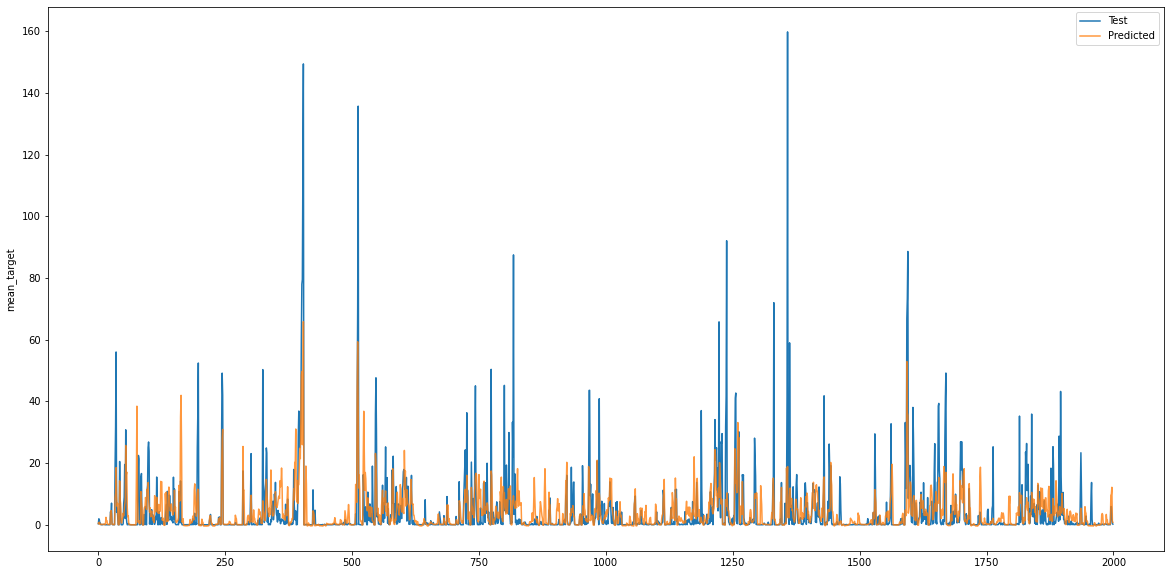

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.lineplot(range(len(y_test[:2000])), y_test[:2000], label='Test')
sns.lineplot(range(len(y_pred[:2000])), y_pred[:2000], label='Predicted', alpha=0.8)

plt.show()

**By visualizing the test vs the predicted data, it is clear that model is able to predict the general trend (if raining or not), but it is often not able to predict the magnitude of the precipitation.**